In [388]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
from timezonefinder import TimezoneFinder
import pytz

### Load Data

In [415]:
X = pd.read_csv('../results/csvs/training_data_2022-11_to_2023-03.csv')
y = pd.read_csv('../data/IrvineSpectrumCenter_parking_2022-11_to_2023-03.csv')
lot_ids = list(X['pk_lot'].unique())
y = y[y['pk_lot'].isin(lot_ids)]

# remove the -8:00 from the end of the timestamp. I didn't mean to add it in the first place
X['timestamp'] = X['timestamp'].apply(lambda x: x[:-6])
X['timestamp'] = pd.to_datetime(X['timestamp'])
X['timestamp'] = X['timestamp'].dt.tz_localize('UTC')
X['timestamp'] = X['timestamp'].dt.tz_convert('US/Pacific')

# sort by timestamp
X = X.sort_values(by=['timestamp'])
X['timestamp'] = X['timestamp'].dt.tz_convert('US/Pacific')

y['dt_start_date'] = pd.to_datetime(y['dt_start_date'])
y['dt_start_date'] = y['dt_start_date'].dt.round('h')
y['dt_start_date'] = y['dt_start_date'].dt.tz_convert('US/Pacific')
y.drop(columns=['dt_end_date', 'pk_lot_alias', 'f_occupancy_rank'], inplace=True)
X = X.sort_values(by=['timestamp'])
y = y.sort_values(by=['dt_start_date'])
display(X.head(1))
display(y.head(10))

,timestamp,pk_lot,wasserstein,avg_hotspot_distance,avg_log_prob
0,2022-11-09 16:00:00-08:00,329825,0.638311,0.012572,14.146392


,dt_start_date,i_avail,i_occ,f_pct_occ,pk_lot,location,geometry
0,2022-11-01 00:00:00-07:00,138,NaN,31.0,381380,POINT(-117.74155545543 33.6509462183159),"MULTIPOLYGON (((-117.741726902 33.650923943, -..."
1,2022-11-01 00:00:00-07:00,1171,NaN,18.0,387459,POINT(-117.739167661281 33.6474458340334),"MULTIPOLYGON (((-117.739180228 33.648147941, -..."
2,2022-11-01 00:00:00-07:00,197,NaN,18.0,329825,POINT(-117.742706 33.6479646),"MULTIPOLYGON (((-117.74335 33.64835, -117.7420..."
3,2022-11-01 00:00:00-07:00,212,NaN,5.0,375750,POINT(-117.7398482 33.6484276),"MULTIPOLYGON (((-117.74027 33.64827, -117.7402..."
4,2022-11-01 00:00:00-07:00,769,NaN,10.0,380308,POINT(-117.744096689923 33.6488428962109),"MULTIPOLYGON (((-117.744053131 33.649582084, -..."
5,2022-11-01 00:00:00-07:00,1434,NaN,25.0,381381,POINT(-117.743547574184 33.6523127479216),"MULTIPOLYGON (((-117.743790442 33.653241372, -..."
6,2022-11-01 01:00:00-07:00,138,NaN,31.0,381380,POINT(-117.74155545543 33.6509462183159),"MULTIPOLYGON (((-117.741726902 33.650923943, -..."
7,2022-11-01 01:00:00-07:00,1171,NaN,18.0,387459,POINT(-117.739167661281 33.6474458340334),"MULTIPOLYGON (((-117.739180228 33.648147941, -..."
8,2022-11-01 01:00:00-07:00,197,NaN,18.0,329825,POINT(-117.742706 33.6479646),"MULTIPOLYGON (((-117.74335 33.64835, -117.7420..."
9,2022-11-01 01:00:00-07:00,212,NaN,5.0,375750,POINT(-117.7398482 33.6484276),"MULTIPOLYGON (((-117.74027 33.64827, -117.7402..."


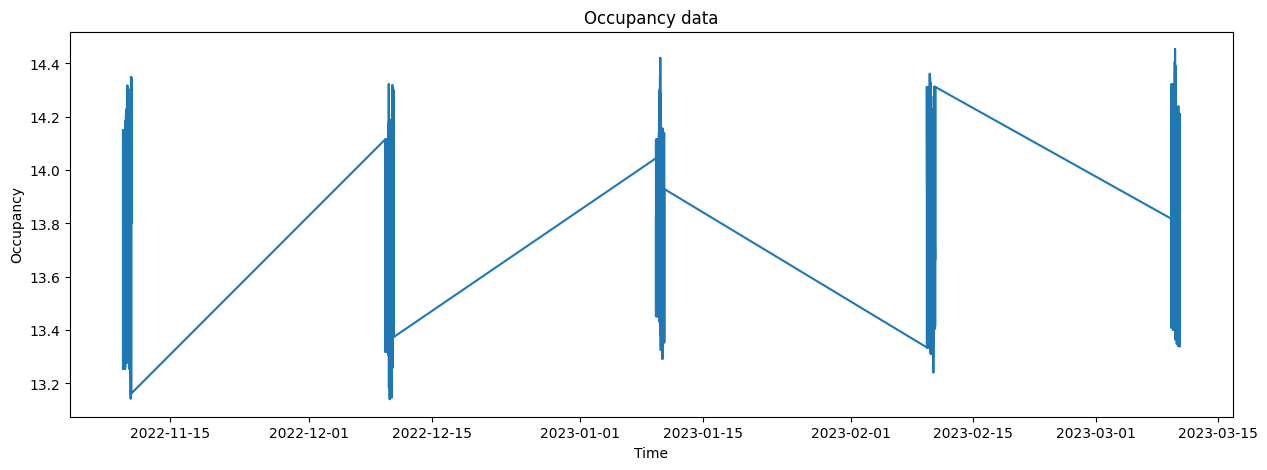

In [416]:
# plot the hours for which we have some data
plt.figure(figsize=(15, 5))
plt.plot(X['timestamp'], X['avg_log_prob'])
plt.xlabel('Time')
plt.ylabel('Occupancy')
plt.title('Occupancy data')
plt.show()

In [417]:
y['timestamp'] = y['dt_start_date'].dt.round('h', ambiguous='NaT')
agg_dict = {'f_pct_occ': 'mean', 'i_avail': 'mean', 'i_occ': 'mean',
            'location': 'first', 'geometry': 'first',}
y = y.groupby(['timestamp', 'pk_lot']).agg(agg_dict).reset_index()
display(y)

,timestamp,pk_lot,f_pct_occ,i_avail,i_occ,location,geometry
0,2022-11-01 00:00:00-07:00,329825,18.0,197.0,NaN,POINT(-117.742706 33.6479646),"MULTIPOLYGON (((-117.74335 33.64835, -117.7420..."
1,2022-11-01 00:00:00-07:00,375750,5.0,212.0,NaN,POINT(-117.7398482 33.6484276),"MULTIPOLYGON (((-117.74027 33.64827, -117.7402..."
2,2022-11-01 00:00:00-07:00,380308,10.0,769.0,NaN,POINT(-117.744096689923 33.6488428962109),"MULTIPOLYGON (((-117.744053131 33.649582084, -..."
3,2022-11-01 00:00:00-07:00,381380,31.0,138.0,NaN,POINT(-117.74155545543 33.6509462183159),"MULTIPOLYGON (((-117.741726902 33.650923943, -..."
4,2022-11-01 00:00:00-07:00,381381,25.0,1434.0,NaN,POINT(-117.743547574184 33.6523127479216),"MULTIPOLYGON (((-117.743790442 33.653241372, -..."
...,...,...,...,...,...,...,...
18511,2023-03-31 00:00:00-07:00,375750,17.0,184.0,NaN,POINT(-117.7398482 33.6484276),"MULTIPOLYGON (((-117.74027 33.64827, -117.7402..."
18512,2023-03-31 00:00:00-07:00,380308,23.0,706.0,NaN,POINT(-117.744096689923 33.6488428962109),"MULTIPOLYGON (((-117.744053131 33.649582084, -..."
18513,2023-03-31 00:00:00-07:00,381380,40.0,119.0,NaN,POINT(-117.74155545543 33.6509462183159),"MULTIPOLYGON (((-117.741726902 33.650923943, -..."
18514,2023-03-31 00:00:00-07:00,381381,24.0,1680.0,NaN,POINT(-117.743547574184 33.6523127479216),"MULTIPOLYGON (((-117.743790442 33.653241372, -..."


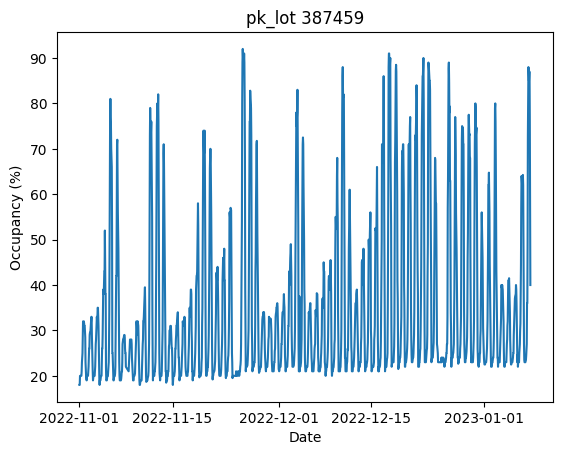

In [418]:
# plot f_pct_occ vs. timestamp for y for first week for random lot
lot_id = np.random.choice(lot_ids)
week_df = y[(y['timestamp'] < '2023-01-08') & (y['pk_lot'] == lot_id)]
plt.plot(week_df['timestamp'], week_df['f_pct_occ'])
plt.xlabel('Date')
plt.ylabel('Occupancy (%)')
plt.title(f'pk_lot {lot_id}')
plt.show()

In [419]:
print(X.shape)
print(y.shape)

# join X and y on timestamp and pk_lot
df = pd.merge(X, y, on=['timestamp', 'pk_lot'], how='inner')
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['timestamp'].dt.dayofweek >= 5

print(df.shape)
display(df.head(2))

(21744, 5)
(18516, 7)
(17562, 13)


,timestamp,pk_lot,wasserstein,avg_hotspot_distance,avg_log_prob,f_pct_occ,i_avail,i_occ,location,geometry,hour,day_of_week,is_weekend
0,2022-11-09 16:00:00-08:00,329825,0.638311,0.012572,14.146392,72.0,68.0,NaN,POINT(-117.742706 33.6479646),"MULTIPOLYGON (((-117.74335 33.64835, -117.7420...",16,2,False
1,2022-11-09 16:00:00-08:00,380308,0.628418,0.020584,13.576987,59.0,367.0,NaN,POINT(-117.744096689923 33.6488428962109),"MULTIPOLYGON (((-117.744053131 33.649582084, -...",16,2,False


### Basic linear regression

In [ ]:
# train a linear regression model using wasserstein and avg_hotspot_distance to predict f_pct_occ
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# input_features = ['wasserstein', 'avg_hotspot_distance', 'hour', 'day_of_week']
input_features = ['wasserstein', 'avg_hotspot_distance', 'day_of_week']

X = df[input_features].values
y = df['f_pct_occ'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LinearRegression()

# train model
model.fit(X_train, y_train)

# evaluate model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')


MSE: 567.464800656175


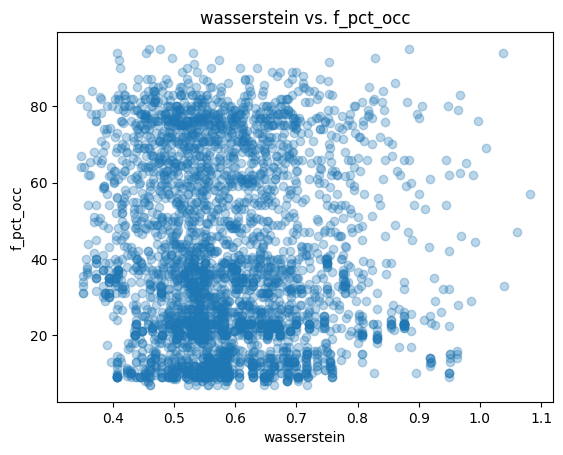

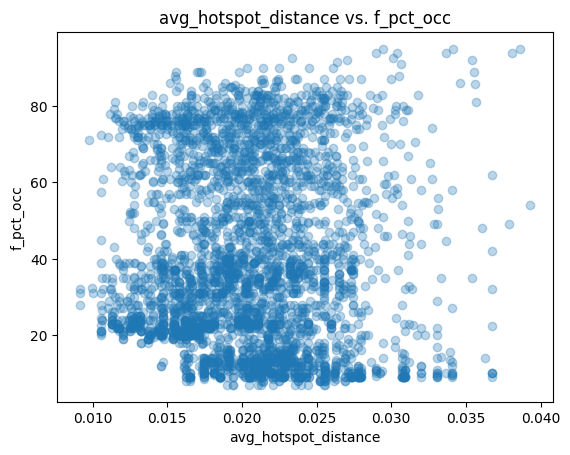

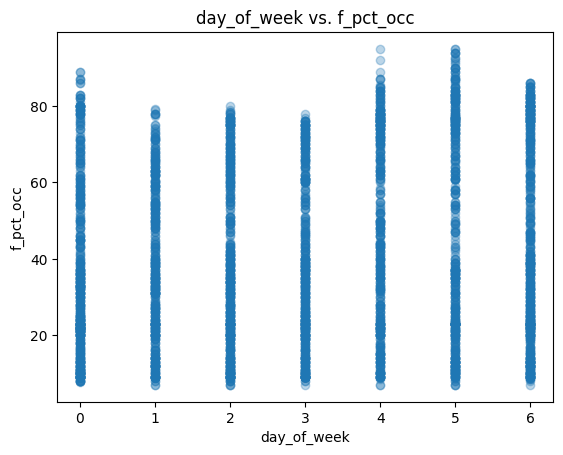

In [ ]:
# plot each input feature vs. f_pct_occ
for feat in input_features:
    plt.scatter(df[feat], df['f_pct_occ'], alpha=0.3)
    plt.xlabel(feat)
    plt.ylabel('f_pct_occ')
    plt.title(f'{feat} vs. f_pct_occ')
    plt.show()

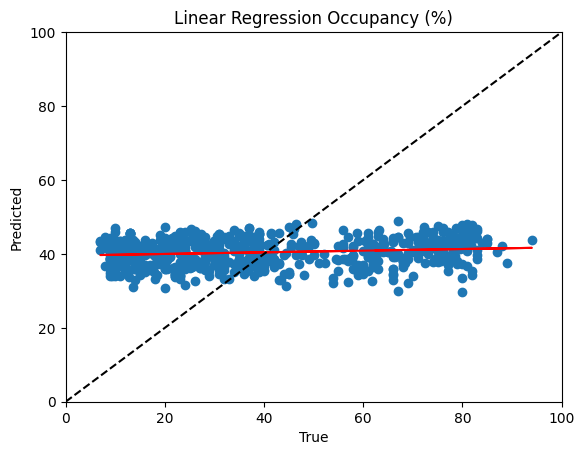

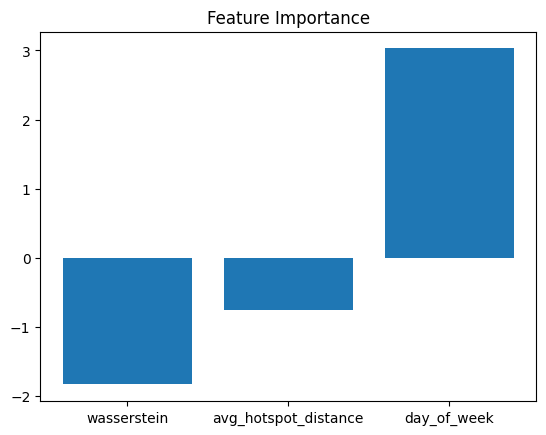

In [ ]:
# plot predictions vs. true values
plt.scatter(y_test, y_pred)
# line of best fit
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b, color='red')
plt.plot([0, 100], [0, 100], color='black', linestyle='--')
plt.xlim(0, 100)
plt.ylim(0, 100)

plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Linear Regression Occupancy (%)')
plt.show()

# plot feature importance
importance = model.coef_
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(ticks=[x for x in range(len(importance))], labels=input_features)
plt.title('Feature Importance')

plt.show()

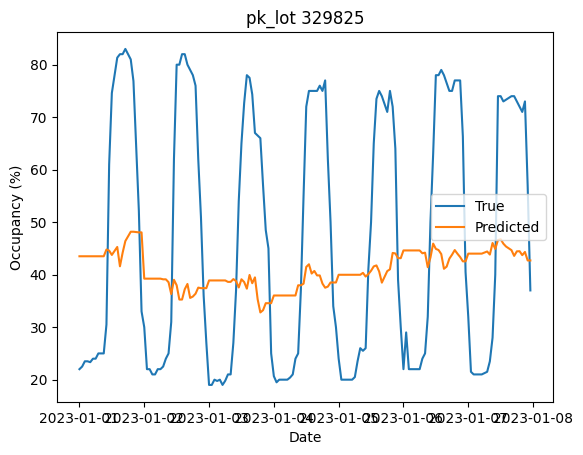

In [ ]:
# plot the predicted time series
# get the first week of data for a random lot
lot_id = np.random.choice(lot_ids)
week_df = df[(df['timestamp'] < '2023-01-08') & (df['pk_lot'] == lot_id)]
X = week_df[input_features].values
X = scaler.transform(X)
y_pred = model.predict(X)

plt.plot(week_df['timestamp'], week_df['f_pct_occ'], label='True')
plt.plot(week_df['timestamp'], y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Occupancy (%)')
plt.title(f'pk_lot {lot_id}')
plt.legend()
plt.show()

### Train a machine learning model to predict the occupancy of a parking lot

At a given time, the model will use metrics about the distribution of trips at that time (call it $\^{X}$) compared to the aggregated distribution of trips over a larger time interval (call it $X$).

We use a shallow multi layered perceptron first with few inputs
- Wasserstein distance between $X$ and $\^{X}$
- Avg distance of cars to their nearest hotspot

In [ ]:
# set directory to src
os.chdir('../src')

from model import Model

In [ ]:
input_features = ['wasserstein', 'avg_hotspot_distance', 'hour', 'day_of_week']

X = df[input_features].values
y = df['f_pct_occ'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Model(input_dim=len(input_features))
model.fit(X_train, y_train, epochs=1000, batch_size=32)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

c:\Users\logan.garwood\AppData\Local\anaconda3\envs\inrixDS\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\logan.garwood\AppData\Local\anaconda3\envs\inrixDS\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE: 533.3453450546713


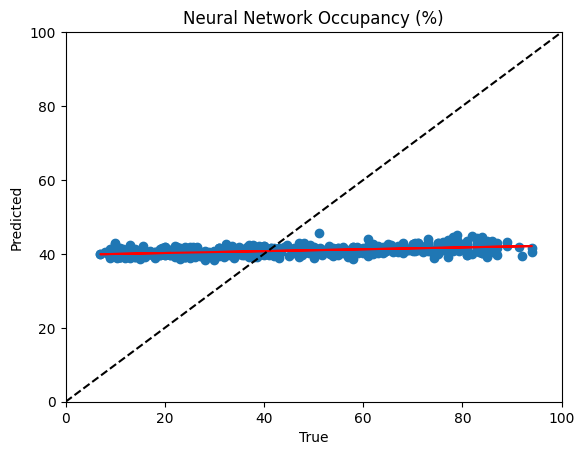

In [ ]:
# plot predictions vs. true values
plt.scatter(y_test, y_pred)
# line of best fit
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b, color='red')
plt.plot([0, 100], [0, 100], color='black', linestyle='--')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Neural Network Occupancy (%)')
plt.show()

### Lets try a Random Forest

In [420]:
# train a random forest regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import random

In [422]:
# input_features = ['wasserstein', 'avg_hotspot_distance', 'day_of_week']
input_features = ['wasserstein', 'avg_hotspot_distance', 'avg_log_prob', 'hour', 'day_of_week']
# input_features = ['hour', 'day_of_week']
output_feature = 'f_pct_occ' #'i_avail'

X = df[input_features].values
y = df[output_feature].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestRegressor(n_estimators=2000, max_depth=50)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

# r^2 value between y_test and y_pred
r2 = r2_score(y_test, y_pred)
print(f'R^2: {r2}')

MSE: 0.06052334421927026
R^2: 0.9998900527303022


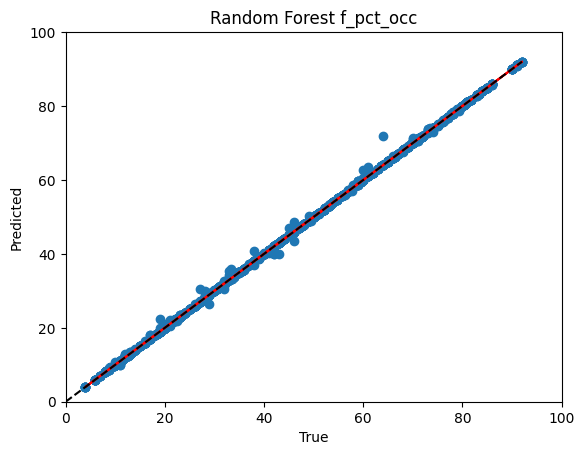

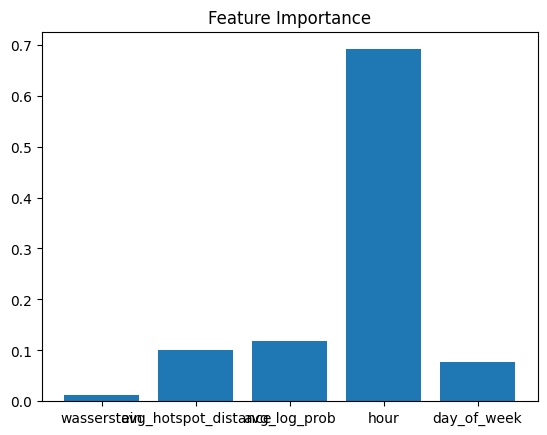

In [423]:
# visualize results
plt.scatter(y_test, y_pred)
# line of best fit
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b, color='red')
max_val = max(max(y_test), max(y_pred))
plt.plot([0, max_val], [0, max_val], color='black', linestyle='--')
if output_feature == 'f_pct_occ':
    plt.xlim(0, 100)
    plt.ylim(0, 100)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title(f'Random Forest {output_feature}')
plt.show()

# plot feature importance
importance = model.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(ticks=[x for x in range(len(importance))], labels=input_features)
plt.title('Feature Importance')
plt.show()

Predicted time series for pk_lot 380308 from 2023-01-1 to 2023-01-31


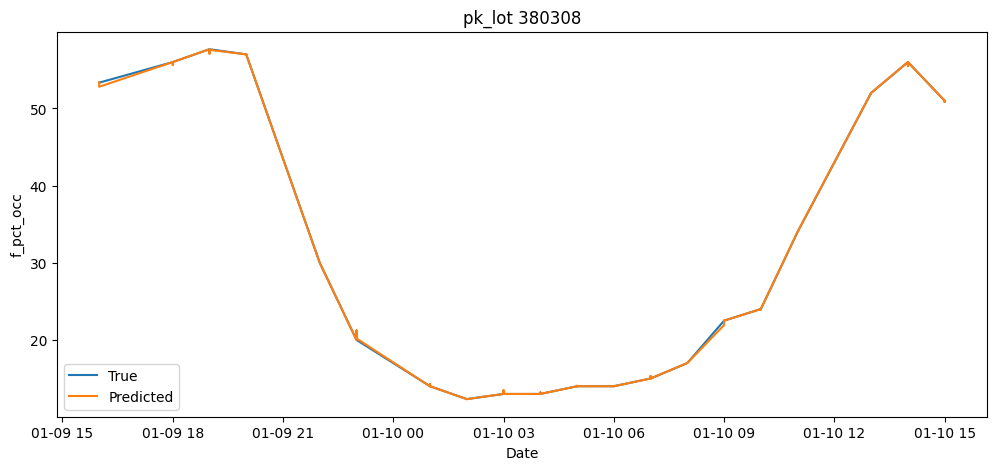

In [424]:
# plot the predicted time series
# get the first week of data for a random lot
lot_id = np.random.choice(lot_ids)
start_day = 1 # random.randint(1, 29)
end_day = 31 # random.randint(start_day + 1, min(start_day + 13, 30))
start_date = '2023-01-' + str(start_day)
end_date = '2023-01-' + str(end_day)
week_df = df[(df['timestamp'] < end_date) & (start_date < df['timestamp']) & (df['pk_lot'] == lot_id)]
# sort week_df
week_df = week_df.sort_values(by=['timestamp'])
week = week_df[input_features].values
week = scaler.transform(week)
week_pred = model.predict(week)

print(f'Predicted time series for pk_lot {lot_id} from {start_date} to {end_date}')

fig = plt.figure(figsize=(12, 5))
plt.plot(week_df['timestamp'], week_df[output_feature], label='True')
plt.plot(week_df['timestamp'], week_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel(output_feature)
plt.title(f'pk_lot {lot_id}')
plt.legend()
plt.show()

In [425]:
from sklearn.tree import plot_tree

# Plot a single tree (e.g., the first tree in the forest)
# plt.figure(figsize=(20, 10))
# plot_tree(model.estimators_[0], feature_names=input_features, filled=True, rounded=True)
# plt.show()